In [49]:
import os
import pandas as pd
import numpy as np
import mysql.connector
from dotenv import load_dotenv
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import tukey_hsd
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [20]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [21]:
# DB 연결
load_dotenv()

conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database="suwon_business"
)

cursor = conn.cursor()

In [22]:
# 쿼리 정의
query = """
SELECT
    t.transaction_date,
    t.district_code,
    d.name AS district_name,
    t.time_block_code,
    t.gender,
    t.age_group_code,
    t.day_of_week,
    t.transaction_amount,
    t.transaction_count,
    w.avg_temp,
    w.max_temp,
    w.min_temp
FROM card_transaction t
JOIN district d ON t.district_code = d.district_id
JOIN weather w ON t.transaction_date = w.weather_date AND t.district_code = w.district_id
"""

df = pd.read_sql(query, conn)
conn.close()

df

/var/folders/36/pdpmp_4s2wv687klck6zglrm0000gn/T/ipykernel_44763/260202010.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,transaction_date,district_code,district_name,time_block_code,gender,age_group_code,day_of_week,transaction_amount,transaction_count,avg_temp,max_temp,min_temp
0,2024-08-01,41111,장안구,1,F,3,4,19556,3,29.2290,33.5963,24.861700
1,2024-08-01,41111,장안구,1,M,2,4,4010,2,29.2290,33.5963,24.861700
2,2024-08-01,41111,장안구,1,M,3,4,14393,3,29.2290,33.5963,24.861700
3,2024-08-01,41111,장안구,1,M,4,4,876,2,29.2290,33.5963,24.861700
4,2024-08-01,41111,장안구,1,M,5,4,939,2,29.2290,33.5963,24.861700
...,...,...,...,...,...,...,...,...,...,...,...,...
1603317,2025-03-31,41117,영통구,10,F,4,1,17503,2,8.0829,15.6633,0.502481
1603318,2025-03-31,41117,영통구,10,F,6,1,102472,2,8.0829,15.6633,0.502481
1603319,2025-03-31,41117,영통구,10,M,3,1,3442,2,8.0829,15.6633,0.502481
1603320,2025-03-31,41117,영통구,10,M,5,1,135210,3,8.0829,15.6633,0.502481


In [23]:
df.columns

Index(['transaction_date', 'district_code', 'district_name', 'time_block_code',
       'gender', 'age_group_code', 'day_of_week', 'transaction_amount',
       'transaction_count', 'avg_temp', 'max_temp', 'min_temp'],
      dtype='object')

In [24]:
df.count()

transaction_date      1603322
district_code         1603322
district_name         1603322
time_block_code       1603322
gender                1603322
age_group_code        1603322
day_of_week           1603322
transaction_amount    1603322
transaction_count     1603322
avg_temp              1603322
max_temp              1603322
min_temp              1603322
dtype: int64

In [25]:
df.info

<bound method DataFrame.info of         transaction_date  district_code district_name  time_block_code gender  \
0             2024-08-01          41111           장안구                1      F   
1             2024-08-01          41111           장안구                1      M   
2             2024-08-01          41111           장안구                1      M   
3             2024-08-01          41111           장안구                1      M   
4             2024-08-01          41111           장안구                1      M   
...                  ...            ...           ...              ...    ...   
1603317       2025-03-31          41117           영통구               10      F   
1603318       2025-03-31          41117           영통구               10      F   
1603319       2025-03-31          41117           영통구               10      M   
1603320       2025-03-31          41117           영통구               10      M   
1603321       2025-03-31          41117           영통구               10      M

In [26]:
df.isnull().mean().sort_values(ascending=False)

transaction_date      0.0
district_code         0.0
district_name         0.0
time_block_code       0.0
gender                0.0
age_group_code        0.0
day_of_week           0.0
transaction_amount    0.0
transaction_count     0.0
avg_temp              0.0
max_temp              0.0
min_temp              0.0
dtype: float64

In [27]:
df.describe()

,district_code,time_block_code,age_group_code,day_of_week,transaction_amount,transaction_count,avg_temp,max_temp,min_temp
count,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06,1.603322e+06
mean,4.111411e+04,5.464615e+00,5.050107e+00,3.999974e+00,1.773111e+05,1.976734e+01,1.407041e+01,1.897826e+01,9.162558e+00
std,2.268238e+00,2.490763e+00,1.803883e+00,1.995954e+00,4.587060e+05,3.464352e+01,1.073996e+01,1.081094e+01,1.092608e+01
min,4.111100e+04,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,-1.024200e+01,-7.687200e+00,-1.353520e+01
25%,4.111300e+04,3.000000e+00,4.000000e+00,2.000000e+00,1.595700e+04,3.000000e+00,3.514100e+00,8.685690e+00,-1.174090e+00
50%,4.111500e+04,5.000000e+00,5.000000e+00,4.000000e+00,5.194000e+04,8.000000e+00,1.584370e+01,2.152600e+01,9.902900e+00
75%,4.111700e+04,8.000000e+00,6.000000e+00,6.000000e+00,1.595068e+05,2.000000e+01,2.359820e+01,2.786330e+01,1.917180e+01
max,4.111700e+04,1.000000e+01,1.100000e+01,7.000000e+00,5.460398e+07,1.009000e+03,3.020880e+01,3.512770e+01,2.625530e+01


In [28]:
df.shape

(1603322, 12)

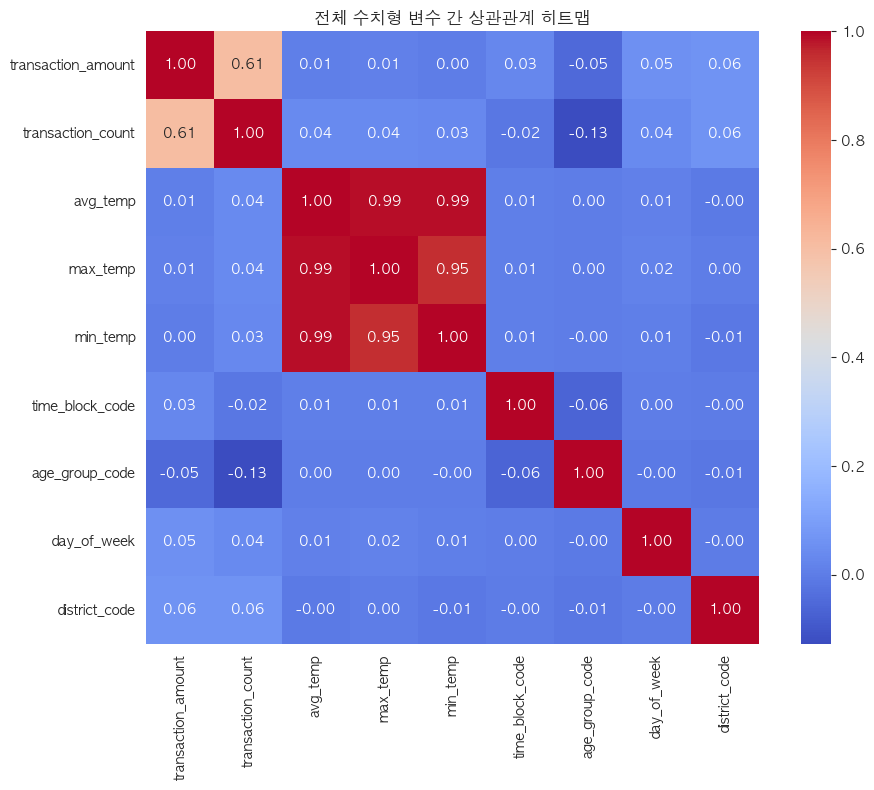

In [115]:
# 상관관계 분석 대상 수치형 컬럼만 선택
numeric_cols = [
    'transaction_amount', 'transaction_count',
    'avg_temp', 'max_temp', 'min_temp',
    'time_block_code', 'age_group_code',
    'day_of_week', 'district_code'
]

# 데이터프레임에서 숫자형 열 추출
corr_df = df[numeric_cols]

# 상관관계 행렬 계산
corr_matrix = corr_df.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("전체 수치형 변수 간 상관관계 히트맵")
plt.tight_layout()
plt.show()

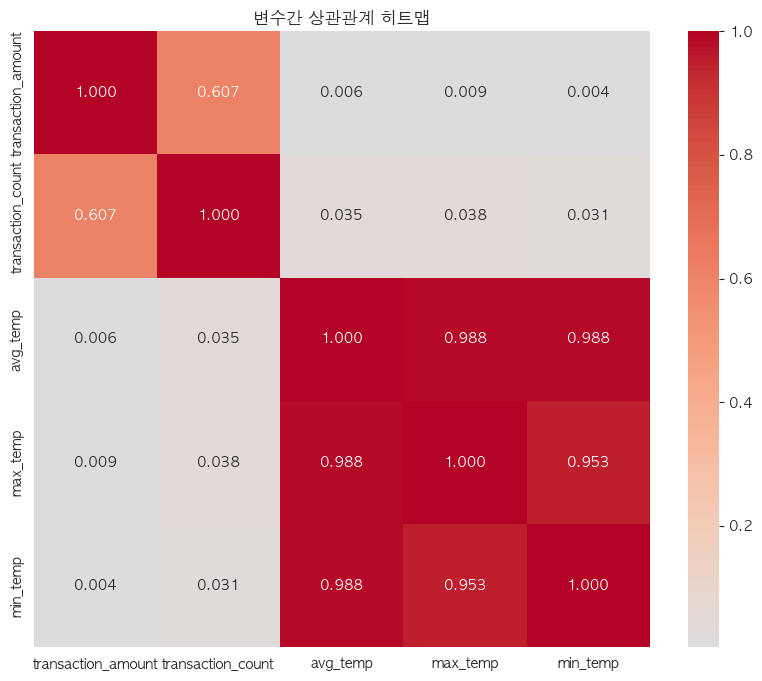

📈 통계적 유의성 검정
평균기온-매출 상관계수: 0.0064 (p-value: 0.000000)
평균기온-거래건수 상관계수: 0.0351 (p-value: 0.000000)



In [29]:
# 상관계수 계산
correlation_vars = ['transaction_amount', 'transaction_count', 'avg_temp', 'max_temp', 'min_temp']
correlation_matrix = df[correlation_vars].corr()

# 상관계수 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('변수간 상관관계 히트맵')
plt.show()


# 통계적 유의성 검정
print("📈 통계적 유의성 검정")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"평균기온-매출 상관계수: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"평균기온-거래건수 상관계수: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")
print()

In [30]:
# 통계적 유의성 검정
print("📈 통계적 유의성 검정")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"평균기온-매출 상관계수: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"평균기온-거래건수 상관계수: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")
print()

📈 통계적 유의성 검정
평균기온-매출 상관계수: 0.0064 (p-value: 0.000000)
평균기온-거래건수 상관계수: 0.0351 (p-value: 0.000000)



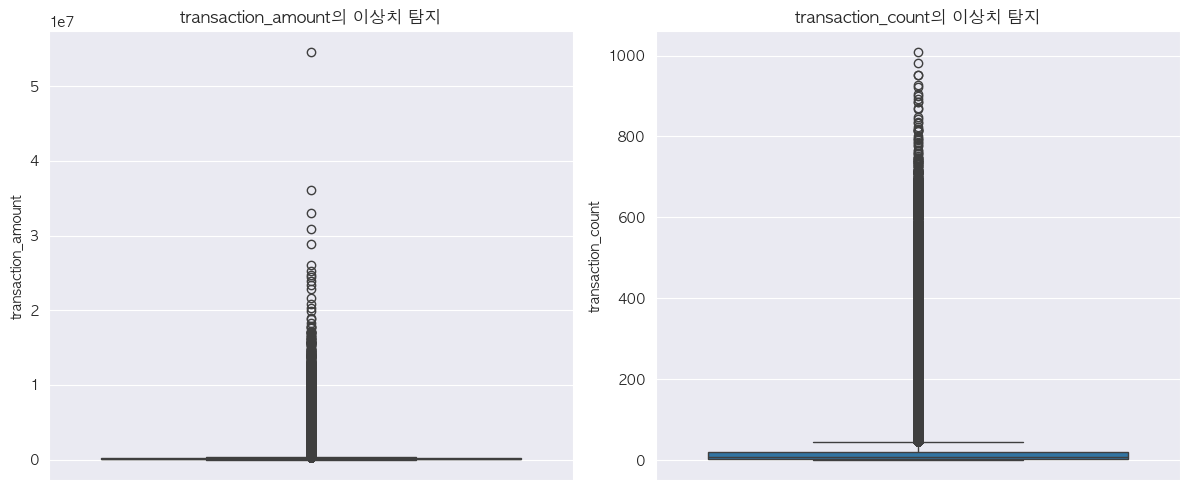

In [31]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(['transaction_amount', 'transaction_count']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'{col}의 이상치 탐지')
plt.tight_layout()
plt.show()

In [32]:
def remove_outliers_iqr(df, columns):
    mask = pd.Series([True] * len(df))
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= df[col].between(lower_bound, upper_bound)
    return df[mask]

In [33]:
target_cols = ['transaction_amount', 'transaction_count']

# 이상치 제거된 데이터프레임 생성
df_no_outliers = remove_outliers_iqr(df, target_cols)

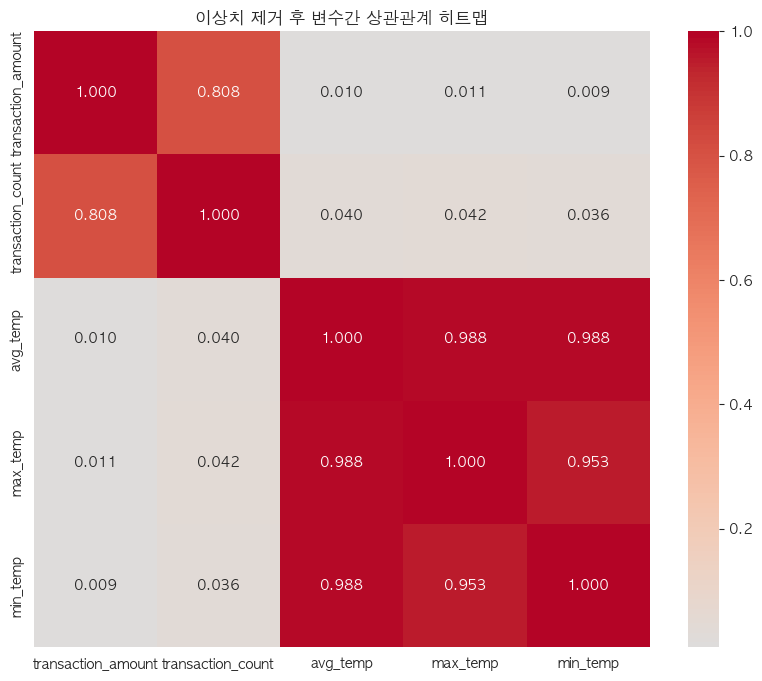

In [36]:
correlation_vars = ['transaction_amount', 'transaction_count',
                    'avg_temp', 'max_temp', 'min_temp']

# 상관계수 계산
correlation_matrix = df_no_outliers[correlation_vars].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('이상치 제거 후 변수간 상관관계 히트맵')
plt.show()

In [ ]:
df.groupby('day_of_week')['transaction_amount'].describe()

## 요일(X:day_of_week)에 따른 평균 커피 매출(y: amt) 은 영향이 없다.

In [113]:
print("=== 요일별 매출 현황 ===")
daily_stats = df.groupby('day_of_week')['transaction_amount'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
])
print(daily_stats)

# 실질적 차이 크기
daily_mean = df.groupby('day_of_week')['transaction_amount'].mean()
print(f"\n최고 vs 최저 매출 차이: {daily_mean.max() - daily_mean.min():,.0f}원")
print(f"상대적 차이: {(daily_mean.max() / daily_mean.min() - 1) * 100:.1f}%")

=== 요일별 매출 현황 ===
              count           mean   median            std  min       max
day_of_week                                                              
1            230486  149324.463061  46413.5  376978.947870   78  36056981
2            226344  152953.161648  48032.5  363667.786231    0  30926732
3            227411  166518.077138  50063.0  447447.609970   47  54603977
4            228312  159682.488485  49110.5  392710.464240   14  33031231
5            233617  170925.519829  53159.0  395002.485975   47  23394538
6            233557  230450.491255  63406.0  591265.036788   94  17697419
7            223595  210960.372965  56300.0  577198.120049   94  20785693

최고 vs 최저 매출 차이: 81,126원
상대적 차이: 54.3%


In [77]:
groups = [group['transaction_amount'].values for name, group in df.groupby('day_of_week')]
day_names = ['월', '화', '수', '목', '금', '토', '일']

# 모든 요일 쌍에 대해 t-검정
for i, j in combinations(range(7), 2):
    t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
    if p_val < 0.05:
        print(f'{day_names[i]}요일 vs {day_names[j]}요일: 유의한 차이 (p={p_val:.6f})')

월요일 vs 화요일: 유의한 차이 (p=0.000932)
월요일 vs 수요일: 유의한 차이 (p=0.000000)
월요일 vs 목요일: 유의한 차이 (p=0.000000)
월요일 vs 금요일: 유의한 차이 (p=0.000000)
월요일 vs 토요일: 유의한 차이 (p=0.000000)
월요일 vs 일요일: 유의한 차이 (p=0.000000)
화요일 vs 수요일: 유의한 차이 (p=0.000000)
화요일 vs 목요일: 유의한 차이 (p=0.000000)
화요일 vs 금요일: 유의한 차이 (p=0.000000)
화요일 vs 토요일: 유의한 차이 (p=0.000000)
화요일 vs 일요일: 유의한 차이 (p=0.000000)
수요일 vs 목요일: 유의한 차이 (p=0.000000)
수요일 vs 금요일: 유의한 차이 (p=0.000388)
수요일 vs 토요일: 유의한 차이 (p=0.000000)
수요일 vs 일요일: 유의한 차이 (p=0.000000)
목요일 vs 금요일: 유의한 차이 (p=0.000000)
목요일 vs 토요일: 유의한 차이 (p=0.000000)
목요일 vs 일요일: 유의한 차이 (p=0.000000)
금요일 vs 토요일: 유의한 차이 (p=0.000000)
금요일 vs 일요일: 유의한 차이 (p=0.000000)
토요일 vs 일요일: 유의한 차이 (p=0.000000)


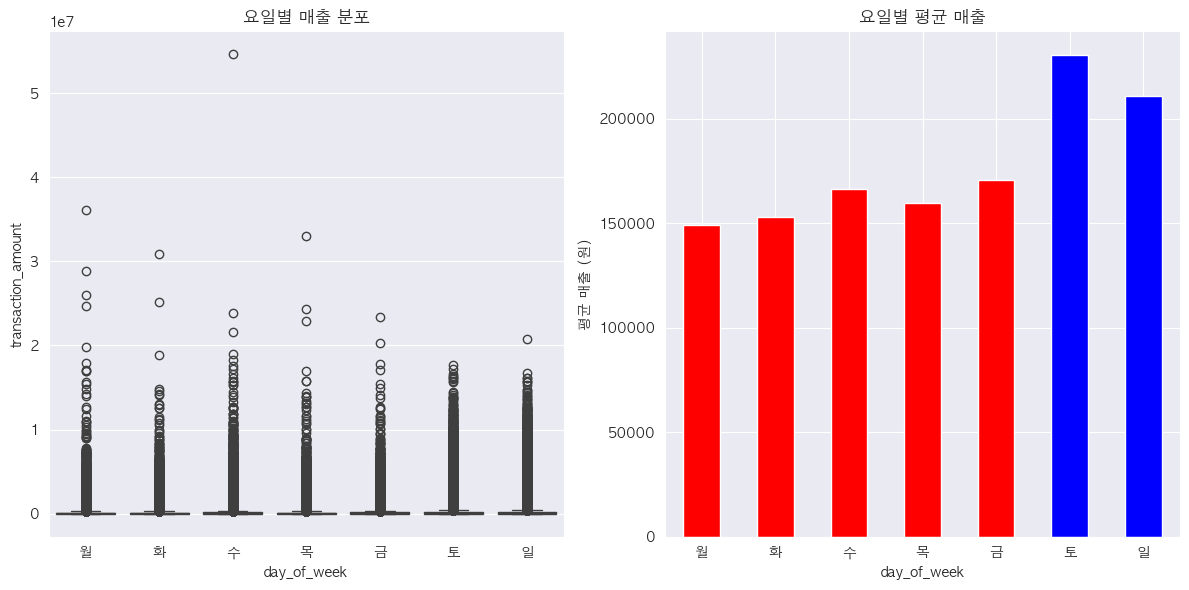

In [71]:
# 1-1. 요일별 매출 분포 박스플롯
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='day_of_week', y='transaction_amount')
plt.title('요일별 매출 분포')
plt.xticks(range(7), ['월', '화', '수', '목', '금', '토', '일'])

# 1-2. 요일별 평균 매출 막대그래프
plt.subplot(1, 2, 2)
daily_avg = df.groupby('day_of_week')['transaction_amount'].mean()
daily_avg.plot(kind='bar', color=['red' if i < 5 else 'blue' for i in range(7)])
plt.title('요일별 평균 매출')
plt.xticks(range(7), ['월', '화', '수', '목', '금', '토', '일'], rotation=0)
plt.ylabel('평균 매출 (원)')
plt.tight_layout()
plt.show()

In [102]:
groups = [group['transaction_amount'].values for name, group in df.groupby('day_of_week')]
day_names = ['월', '화', '수', '목', '금', '토', '일']

# 모든 요일 쌍에 대해 t-검정
for i, j in combinations(range(7), 2):
    t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
    if p_val < 0.05:
        print(f'{day_names[i]}요일 vs {day_names[j]}요일: 유의한 차이 (p={p_val:.6f})')


월요일 vs 화요일: 유의한 차이 (p=0.000932)
월요일 vs 수요일: 유의한 차이 (p=0.000000)
월요일 vs 목요일: 유의한 차이 (p=0.000000)
월요일 vs 금요일: 유의한 차이 (p=0.000000)
월요일 vs 토요일: 유의한 차이 (p=0.000000)
월요일 vs 일요일: 유의한 차이 (p=0.000000)
화요일 vs 수요일: 유의한 차이 (p=0.000000)
화요일 vs 목요일: 유의한 차이 (p=0.000000)
화요일 vs 금요일: 유의한 차이 (p=0.000000)
화요일 vs 토요일: 유의한 차이 (p=0.000000)
화요일 vs 일요일: 유의한 차이 (p=0.000000)
수요일 vs 목요일: 유의한 차이 (p=0.000000)
수요일 vs 금요일: 유의한 차이 (p=0.000388)
수요일 vs 토요일: 유의한 차이 (p=0.000000)
수요일 vs 일요일: 유의한 차이 (p=0.000000)
목요일 vs 금요일: 유의한 차이 (p=0.000000)
목요일 vs 토요일: 유의한 차이 (p=0.000000)
목요일 vs 일요일: 유의한 차이 (p=0.000000)
금요일 vs 토요일: 유의한 차이 (p=0.000000)
금요일 vs 일요일: 유의한 차이 (p=0.000000)
토요일 vs 일요일: 유의한 차이 (p=0.000000)


In [104]:
# 분산 분석
f_stat, p_value = stats.f_oneway(*[group['transaction_amount'].values
                                   for name, group in df.groupby('day_of_week')])
print(f'F-statistic: {f_stat}, p-value: {p_value}')

F-statistic: 1061.2332676886479, p-value: 0.0


In [108]:
#회귀 분석
df_regression = pd.get_dummies(df, columns=['day_of_week', 'gender', 'age_group_code', 'time_block_code'])

X = df_regression.drop(['transaction_amount', 'transaction_date', 'district_code', 'district_name'], axis=1)
y = df_regression['transaction_amount']


독립변수 개수: 36
샘플 개수: 1603322
주요 독립변수들:
['transaction_count', 'avg_temp', 'max_temp', 'min_temp', 'amount_per_txn', 'temp_range', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']


In [111]:
model = LinearRegression()
model.fit(X, y)

# 요일 변수들의 회귀계수 추출
day_coefficients = {}
for col in X.columns:
    if 'day_of_week' in col:
        coef_index = list(X.columns).index(col)
        day_coefficients[col] = model.coef_[coef_index]

print("요일별 회귀계수 (다른 조건 동일할 때 매출 차이):")
for day, coef in sorted(day_coefficients.items()):
    day_num = day.split('_')[-1]
    print(f"요일 {day_num}: {coef:,.0f}원")

요일별 회귀계수 (다른 조건 동일할 때 매출 차이):
요일 1: -12,433원
요일 2: -10,581원
요일 3: -5,070원
요일 4: -8,383원
요일 5: -4,898원
요일 6: 22,147원
요일 7: 19,218원


In [112]:
X_no_day = X[[col for col in X.columns if 'day_of_week' not in col]]
model_no_day = LinearRegression()
model_no_day.fit(X_no_day, y)

# 모델 성능 비교
r2_full = model.score(X, y)        # 요일 포함 모델의 설명력
r2_no_day = model_no_day.score(X_no_day, y)  # 요일 제외 모델의 설명력

day_contribution = r2_full - r2_no_day

print(f"전체 모델 설명력 (R²): {r2_full:.4f}")
print(f"요일 제외 모델 설명력 (R²): {r2_no_day:.4f}")
print(f"요일 변수의 순수 기여도: {day_contribution:.4f}")
print(f"요일 변수의 기여 비율: {day_contribution/r2_full*100:.1f}%")

전체 모델 설명력 (R²): 0.4816
요일 제외 모델 설명력 (R²): 0.4807
요일 변수의 순수 기여도: 0.0008
요일 변수의 기여 비율: 0.2%


## "연령대별 매출 소비 수준에 차이가 없다:

In [105]:
# 1-1. 연령대 현황 파악
print("1. 연령대별 기본 현황:")
age_counts = df['age_group_code'].value_counts().sort_index()
print("연령대별 고객 수:")
for age_code, count in age_counts.items():
    percentage = count / len(df) * 100
    print(f"연령대 {age_code}: {count:,}명 ({percentage:.1f}%)")

1. 연령대별 기본 현황:
연령대별 고객 수:
연령대 1: 2명 (0.0%)
연령대 2: 103,729명 (6.5%)
연령대 3: 281,578명 (17.6%)
연령대 4: 282,196명 (17.6%)
연령대 5: 279,431명 (17.4%)
연령대 6: 273,802명 (17.1%)
연령대 7: 225,341명 (14.1%)
연령대 8: 118,600명 (7.4%)
연령대 9: 36,622명 (2.3%)
연령대 10: 2,014명 (0.1%)
연령대 11: 7명 (0.0%)


In [114]:
age_stats = df.groupby('age_group_code')['transaction_amount'].describe()
age_stats

,count,mean,std,min,25%,50%,75%,max
age_group_code,,,,,,,,
1,2.0,3363.500000,2544.877305,1564.0,2463.75,3363.5,4263.25,5163.0
2,103729.0,20834.771453,41762.472343,78.0,4693.00,9800.0,22997.00,7571965.0
3,281578.0,177927.642781,349408.194838,152.0,18398.00,55220.0,170953.75,17697419.0
4,282196.0,244193.144038,505541.735005,14.0,29881.00,84861.0,244936.00,33031231.0
5,279431.0,271524.629579,661975.492036,94.0,32090.00,95081.0,268371.50,54603977.0
6,273802.0,212304.141467,523778.331077,141.0,27901.00,82654.0,213878.75,28823436.0
7,225341.0,103323.008520,298783.046045,0.0,14659.00,39916.0,97677.00,16919934.0
8,118600.0,40996.321821,122840.893255,47.0,6884.00,16270.0,36995.00,7826580.0
9,36622.0,25192.532822,81464.113400,16.0,5365.00,11264.0,23467.00,4780976.0


In [84]:
age_mean = df.groupby('age_group_code')['transaction_amount'].mean().sort_values(ascending=False)
for i, (age_code, avg_amount) in enumerate(age_mean.items(), 1):
    print(f"{i}위. 연령대 {age_code}: {avg_amount:,.0f}원")

1위. 연령대 5: 271,525원
2위. 연령대 4: 244,193원
3위. 연령대 6: 212,304원
4위. 연령대 3: 177,928원
5위. 연령대 7: 103,323원
6위. 연령대 11: 45,302원
7위. 연령대 8: 40,996원
8위. 연령대 9: 25,193원
9위. 연령대 10: 22,399원
10위. 연령대 2: 20,835원
11위. 연령대 1: 3,364원


In [96]:
highest_age = age_mean.index[0]
lowest_age = age_mean.index[-1]
highest_amount = age_mean.iloc[0]
lowest_amount = age_mean.iloc[-1]

print(f"최고 소비: 연령대 {highest_age} ({highest_amount:,.0f}원)")
print(f"최저 소비: 연령대 {lowest_age} ({lowest_amount:,.0f}원)")
print(f"절대 차이: {highest_amount - lowest_amount:,.0f}원")
print(f"상대 차이: {(highest_amount / lowest_amount - 1) * 100:.1f}%")

최고 소비: 연령대 5 (271,525원)
최저 소비: 연령대 1 (3,364원)
절대 차이: 268,161원
상대 차이: 7972.7%


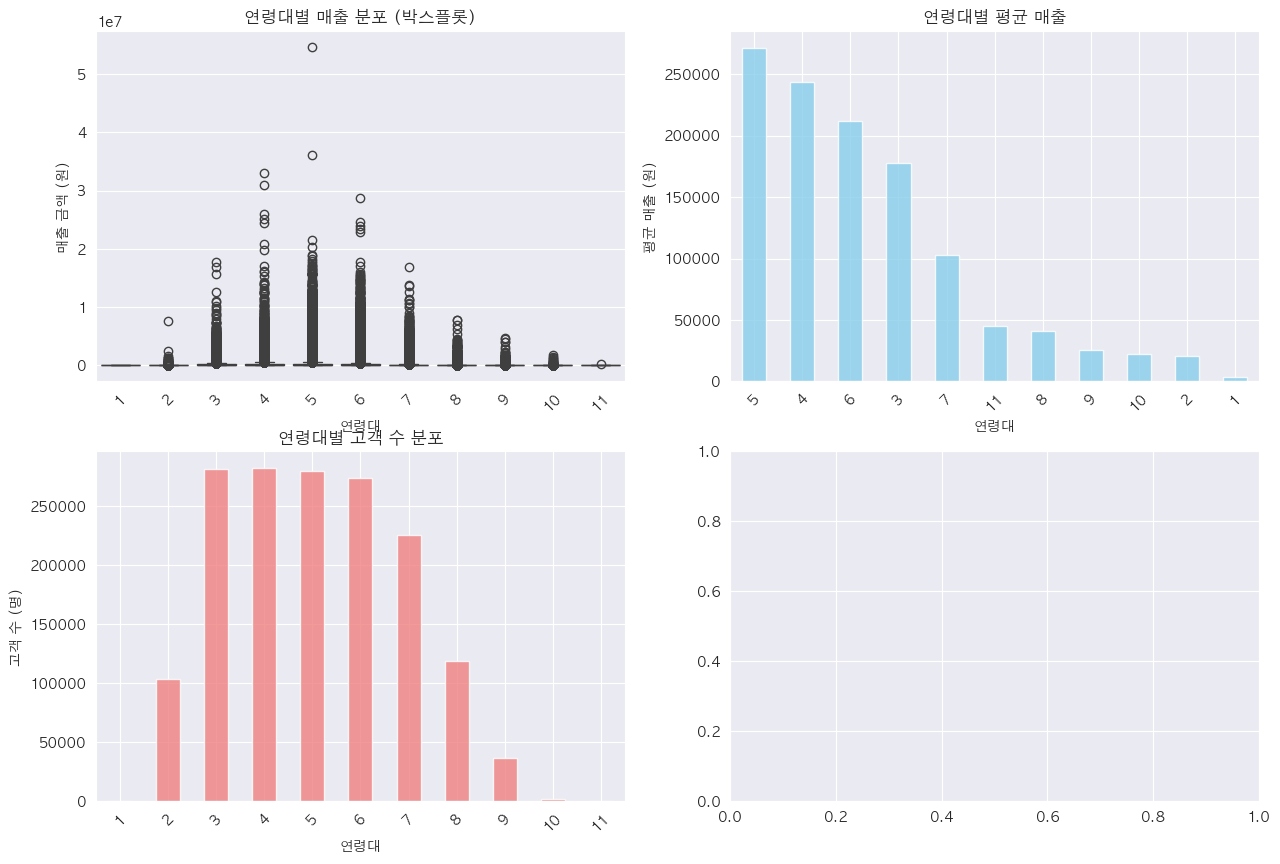

In [92]:
# 1-5. 연령대별 소비 분포 시각화
fig, axes = plt.subplots(2,2, figsize=(15, 10))

# 박스플롯 - 연령대별 매출 분포
sns.boxplot(data=df, x='age_group_code', y='transaction_amount', ax=axes[0,0])
axes[0,0].set_title('연령대별 매출 분포 (박스플롯)')
axes[0,0].set_xlabel('연령대')
axes[0,0].set_ylabel('매출 금액 (원)')
axes[0,0].tick_params(axis='x', rotation=45)

# 막대그래프 - 연령대별 평균 매출
age_mean.plot(kind='bar', ax=axes[0,1], color='skyblue', alpha=0.8)
axes[0,1].set_title('연령대별 평균 매출')
axes[0,1].set_xlabel('연령대')
axes[0,1].set_ylabel('평균 매출 (원)')
axes[0,1].tick_params(axis='x', rotation=45)

# 고객 수 분포
age_counts.plot(kind='bar', ax=axes[1,0], color='lightcoral', alpha=0.8)
axes[1,0].set_title('연령대별 고객 수 분포')
axes[1,0].set_xlabel('연령대')
axes[1,0].set_ylabel('고객 수 (명)')
axes[1,0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [94]:
print("\n5. 소비 수준별 연령대 그룹화:")
age_mean_sorted = age_mean.sort_values(ascending=False)
total_ages = len(age_mean_sorted)

# 3등분으로 그룹화
high_spenders = age_mean_sorted.iloc[:total_ages//3]
medium_spenders = age_mean_sorted.iloc[total_ages//3:2*total_ages//3]
low_spenders = age_mean_sorted.iloc[2*total_ages//3:]

print("고소비군 (상위 1/3):")
for age_code, amount in high_spenders.items():
    print(f"  연령대 {age_code}: {amount:,.0f}원")

print("중간소비군 (중위 1/3):")
for age_code, amount in medium_spenders.items():
    print(f"  연령대 {age_code}: {amount:,.0f}원")

print("저소비군 (하위 1/3):")
for age_code, amount in low_spenders.items():
    print(f"  연령대 {age_code}: {amount:,.0f}원")



5. 소비 수준별 연령대 그룹화:
고소비군 (상위 1/3):
  연령대 5: 271,525원
  연령대 4: 244,193원
  연령대 6: 212,304원
중간소비군 (중위 1/3):
  연령대 3: 177,928원
  연령대 7: 103,323원
  연령대 11: 45,302원
  연령대 8: 40,996원
저소비군 (하위 1/3):
  연령대 9: 25,193원
  연령대 10: 22,399원
  연령대 2: 20,835원
  연령대 1: 3,364원


In [97]:
cv_age = df.groupby('age_group_code')['transaction_amount'].agg(['mean', 'std'])
cv_age['cv'] = cv_age['std'] / cv_age['mean']
avg_cv = cv_age['cv'].mean()

if (highest_amount / lowest_amount) > 1.5:  # 50% 이상 차이
    print("가설 기각 가능성 높음 - 연령대별 뚜렷한 소비 차이 관찰")
elif (highest_amount / lowest_amount) > 1.2:  # 20% 이상 차이
    print("가설 기각 가능성 있음 - 연령대별 중간 정도 차이 관찰")
else:
    print("가설 채택 가능성 있음 - 연령대별 차이가 미미")

print(f"최대 연령대 간 차이: {(highest_amount / lowest_amount - 1) * 100:.1f}%")
print(f"연령대별 평균 변동계수: {avg_cv:.2f}")

가설 기각 가능성 높음 - 연령대별 뚜렷한 소비 차이 관찰
최대 연령대 간 차이: 7972.7%
연령대별 평균 변동계수: 2.37


In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 변수 선택
features = ['age_group_code', 'gender']  # 필요시 추가
X = df[features]
y = df['transaction_amount']

# 범주형 인코딩
X = pd.get_dummies(X, columns=['age_group_code', 'gender'], drop_first=True)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.0f}원")
print(f"RMSE: {rmse:,.0f}원")
print(f"R² Score: {r2:.4f}")

MAE: 187,102원
RMSE: 445,926원
R² Score: 0.0330
